## 자료 가져오기

In [1]:
# 영상처리에 있어서 핵심적인 matplotlib과 opencv , numpy 가져오기
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
if not os.path.exists("len_top.jpg"):
    # 영상처리에 있어서 가장 많이 이용되는 Lena 이미지 활용하기
    !wget http://www.lenna.org/len_top.jpg

## Objective

1. scaling에 대한 이해
2. rotation에 대한 이해
3. transition에 대한 이해

<h1 style = "background-color: rgba(185, 109, 106, 0.3);" > RST 변환이란?</h1>

> Rotation, Scaling, Transition 이 기하학 처리에서의 3대 변환이다. 이것을 어떻게 opencv에서 다루는지 파악해보자.

### 1) Scaling

$$
X' = X * ratio_x, Y' = Y * ratio_y
$$

이 부분은 일전에도 다루었듯이 `cv2.resize`를 통해서도 쉽게 구현이 가능했다. 다시 복습 겸 확인해보자 .

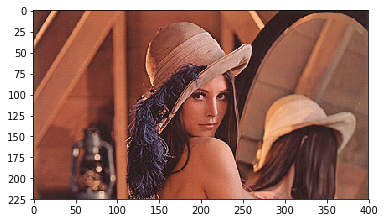

In [17]:
image = cv2.imread("./len_top.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

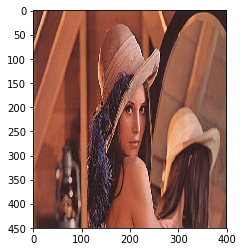

In [18]:
target = cv2.resize(image,None,fx=1.0,fy=2.)

plt.imshow(target)
plt.show()

하지만 좀 더 이론적으로 접근한다면, 위의 수식을 Affine Matrix로 풀어볼 수 있다.

$$
\begin{pmatrix} x' \\ y' \\ t' \end{pmatrix} = \begin{pmatrix} ratio_x & 0 & 0 \\ 0 & ratio_y & 0 \end{pmatrix} \begin{pmatrix} x \\ y \\ 1 \end{pmatrix}
$$

* (affine matrix는 이후에 다시 구체적으로 설명할 예정, RST 변환 모두를 일반화시킨 식이 affine matrix)

opencv에서는 Affine Matrix를 넣으면 알아서 Mapping해주는 함수가 존재한다.(심지어 biliear interpolation 적용함)



`cv2.warpAffine(src,M,dsize)`
* src - Image
* M - 변환행렬
* dsize(tuple) - output image size(width=columns, height=rows)

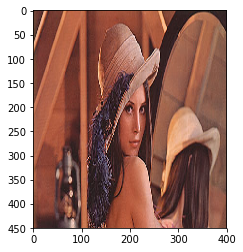

In [19]:
affine_matrix = np.array([
    [1.0,0,  0 ],
    [0  ,2.0,0 ]])

height, width = image.shape[:2]
target_height = height * 2
target_width = width


target = cv2.warpAffine(image, affine_matrix, 
                        (target_width,target_height) )

plt.imshow(target)
plt.show()

### 2) Transition

$$
\begin{pmatrix} x' \\ y' \\ t' \end{pmatrix} = \begin{pmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y \end{pmatrix} \begin{pmatrix} x \\ y \\ 1 \end{pmatrix}
$$


직관적으로 이해하기 쉬운 평행 이동이다.

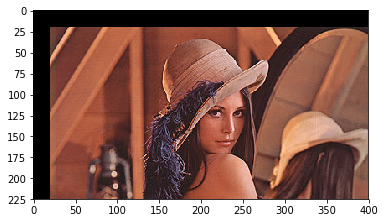

In [21]:
affine_matrix = np.array([
    [1.0,0,  20 ],
    [0  ,1.0,20 ]])

height, width = image.shape[:2]
target_height = height
target_width = width

target = cv2.warpAffine(image, affine_matrix, 
                        (target_width,target_height) )

plt.imshow(target)
plt.show()

### 3) Rotation

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/DistanceFromAtoB_Matrix_Rota.svg/600px-DistanceFromAtoB_Matrix_Rota.svg.png)

$$
\begin{pmatrix} x' \\ y' \\ t' \end{pmatrix} = \begin{pmatrix} cos\theta & -sin\theta & 0 \\ sin\theta & cos\theta & 0 \end{pmatrix} \begin{pmatrix} x \\ y \\ 1 \end{pmatrix}
$$

위의 식을 보면, $(x,y)$가 $\theta$만큼 회전하기 위한 수식이 바로 위의 수식이다. 위의 수식을 바탕으로 30도만큼 회전을 가해보자  


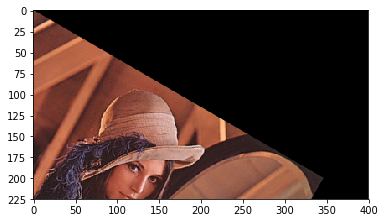

In [13]:
affine_matrix = np.array([
    [np.cos(np.pi/6),-np.sin(np.pi/6),0 ],
    [np.sin(np.pi/6),np.cos(np.pi/6),0 ]])

height, width = image.shape[:2]
target_height = height
target_width = width

target = cv2.warpAffine(image, affine_matrix, 
                        (target_width,target_height) )

plt.imshow(target)
plt.show()

30도만큼 움직였는데, 중심이 아닌 원점을 중심으로 회전하였다. 그렇다면 원점을 중심으로 회전하려면 어떻게 해야 할까? 바로 transition을 먼저 가하고, 그 후 affine matrix로 회전하고, 다시 복구 해야 한다. 

$$
R(\theta) = \begin{pmatrix} cos\theta & -sin\theta & 0 \\ sin\theta & cos\theta & 0 \end{pmatrix}
$$

$$
T(T_x,T_y) = \begin{pmatrix} 1 & 0 & T_x \\ 0 & 1 & T_y \end{pmatrix}
$$

$$
T(center_x,center_y) * R * T(-center_x,-center_y) = 
\begin{pmatrix} cos\theta & -sin\theta & -T_xcos\theta + T_x+T_ysin\theta \\ sin\theta & cos\theta & -T_xsin\theta - T_ycos\theta + T_y \end{pmatrix}
$$

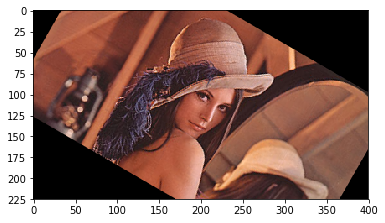

In [16]:
height, width = image.shape[:2]
c_y = height//2
c_x = width//2

theta = np.pi/6

affine_matrix = np.array([
    [np.cos(theta),-np.sin(theta),-c_x*np.cos(theta)+c_x+c_y*np.sin(theta) ],
    [np.sin(theta),np.cos(theta),-c_x*np.sin(theta)-c_y*np.cos(theta)+c_y ]])

height, width = image.shape[:2]
target_height = height
target_width = width

target = cv2.warpAffine(image, affine_matrix, 
                        (target_width,target_height) )

plt.imshow(target)
plt.show()

<hr>

Copyright(c) 2019 by Public AI. All rights reserved. last updated on 2019/02/01<br>
Writen by PAI, SangJae Kang(rocketgrowthsj@publicai.co.kr) 
<hr>